In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta

In [2]:
num_samples = 6000
timestamp_start = datetime(2024, 11, 25, 19, 28, 9)

timestamps = [timestamp_start + timedelta(seconds=i) for i in range(num_samples)]
cpu_temperature = np.random.normal(65, 15, num_samples) 
cpu_usage = np.random.normal(55, 25, num_samples)  
cpu_load = np.random.normal(1.75, 0.75, num_samples) 
memory_usage = np.random.normal(55, 22, num_samples)  
battery_level = np.random.normal(60, 25, num_samples)  
cpu_power = np.random.normal(35, 17, num_samples)  

In [3]:
anomalies = np.random.choice([0, 1], size=num_samples, p=[0.95, 0.05])  
cpu_temperature[anomalies == 1] += np.random.normal(30, 5, anomalies.sum()) 
cpu_usage[anomalies == 1] += np.random.normal(40, 10, anomalies.sum())  
memory_usage[anomalies == 1] += np.random.normal(40, 10, anomalies.sum()) 

In [4]:
df = pd.DataFrame({
    'timestamp': timestamps,
    'cpu_temperature': cpu_temperature,
    'cpu_usage': cpu_usage,
    'cpu_load': cpu_load,
    'memory_usage': memory_usage,
    'battery_level': battery_level,
    'cpu_power': cpu_power
})

In [5]:
percentile_low = 5
percentile_high = 95

def detect_anomalies_percentile(df, low, high):
    anomalies = pd.DataFrame()
    for column in ['cpu_temperature', 'cpu_usage', 'memory_usage']:
        low_percentile = np.percentile(df[column], low)
        high_percentile = np.percentile(df[column], high)
        anomalies = anomalies.append(df[(df[column] < low_percentile) | (df[column] > high_percentile)])
        df[f'{column}_anomaly'] = (df[column] < low_percentile) | (df[column] > high_percentile)
    return df, anomalies

df_percentile, anomalies_percentile = detect_anomalies_percentile(df, percentile_low, percentile_high)
anomalies_percentile.to_csv('anomalies_percentile_detected.csv', index=False)

In [6]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['cpu_temperature', 'cpu_usage', 'cpu_load', 'memory_usage', 'battery_level', 'cpu_power']])

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.05)
df['isolation_forest_anomaly'] = iso_forest.fit_predict(scaled_features)
df['isolation_forest_anomaly'] = df['isolation_forest_anomaly'].map({1: 0, -1: 1})

# Isolation Forest anomalies to CSV
anomalies_iforest = df[df['isolation_forest_anomaly'] == 1]
anomalies_iforest.to_csv('anomalies_iforest_detected.csv', index=False)

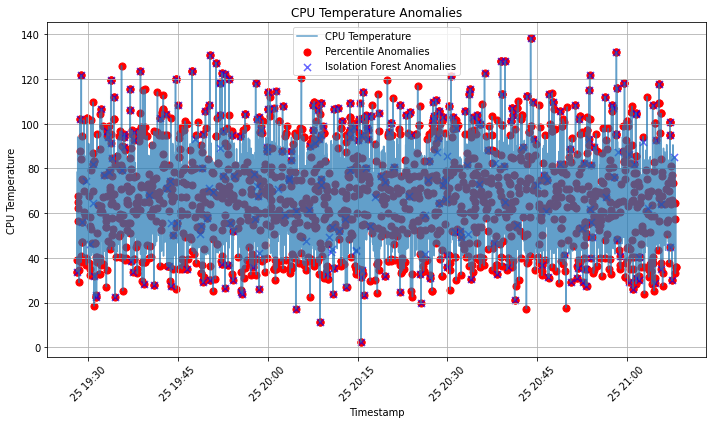

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['cpu_temperature'], label='CPU Temperature', alpha=0.7)
plt.scatter(anomalies_percentile['timestamp'], anomalies_percentile['cpu_temperature'], color='red', label='Percentile Anomalies', marker='o', s=50)
plt.scatter(anomalies_iforest['timestamp'], anomalies_iforest['cpu_temperature'], color='blue', label='Isolation Forest Anomalies', alpha=0.6, marker='x', s=50)
plt.xlabel('Timestamp')
plt.ylabel('CPU Temperature')
plt.title('CPU Temperature Anomalies')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# 5. Correlation Analysis
correlation = df[['cpu_temperature', 'cpu_usage', 'memory_usage']].corr()
print("Correlation Matrix for Detected Anomalies:")
print(correlation)

# 6. Anomaly Summary
print(f"Detected Anomalies (Percentile Method): {len(anomalies_percentile)}")
print(f"Detected Anomalies (Isolation Forest Method): {len(anomalies_iforest)}")

df_clean = df[(df['cpu_temperature_anomaly'] == False) & (df['cpu_usage_anomaly'] == False) & (df['memory_usage_anomaly'] == False)]
df_clean.to_csv('clean_data.csv', index=False)

Correlation Matrix for Detected Anomalies:
                 cpu_temperature  cpu_usage  memory_usage
cpu_temperature         1.000000   0.121527      0.130079
cpu_usage               0.121527   1.000000      0.093782
memory_usage            0.130079   0.093782      1.000000
Detected Anomalies (Percentile Method): 1800
Detected Anomalies (Isolation Forest Method): 300
